In [26]:
# PMI-Macro-Analysis
# The feasibility of using PMI as an economic forecasting indicator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#read the table
df = pd.read_excel(r'D:/python/python 学习/PMI analysis/PMI_DATA.xlsx', header=None)
indicators = df.iloc[1:15, 0].tolist()
dates = df.iloc[0, 2:].tolist()
values = df.iloc[1:15, 2:].to_numpy()

data_list = []
for i, ind in enumerate(indicators):
    for j, date in enumerate(dates):
        val = values[i, j]
        data_list.append({"indicator":ind.replace("(%)", ""), "Date":date, "Value":val})
        
df_long = pd.DataFrame(data_list)
df_long["Value"] = pd.to_numeric(df_long["Value"], errors="coerce")
df_long["Date_dt"] = pd.to_datetime(df_long["Date"], format="%m-%Y")
df_long = df_long.sort_values(by="Date_dt", ascending=True)
pmis = df_long[df_long["indicator"] == 'PMI'].set_index("Date_dt")
pmis = pmis.asfreq("MS")

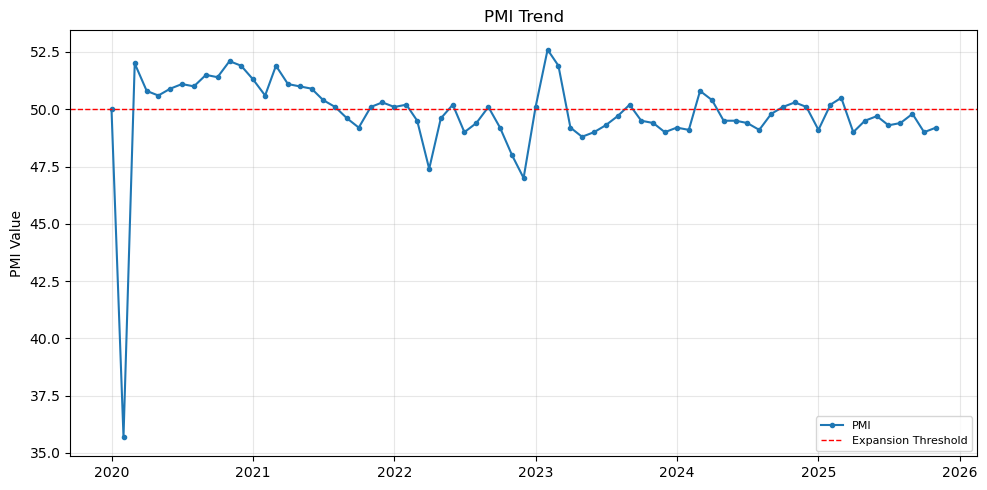

In [27]:
# PMI trend
plt.figure(figsize=(10, 5))
plt.plot(pmis.index, pmis["Value"], label="PMI", marker='o', markersize=3) 
plt.axhline(50, color='red', linestyle="--", label="Expansion Threshold", linewidth=1)
plt.legend(fontsize=8, loc="lower right")
plt.ylabel("PMI Value")
plt.grid(True, alpha=0.3)
plt.title("PMI Trend")
plt.tight_layout()
plt.savefig("D:\PYTHON/pmi_trend.png", bbox_inches='tight')
plt.show()

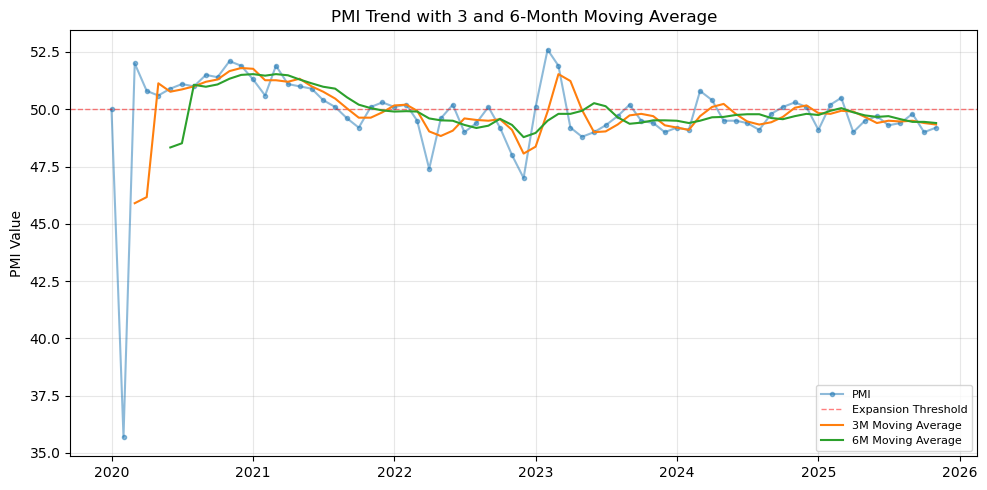

In [28]:
# Moving average

pmis["ma_3m"] = pmis["Value"].rolling(window=3).mean()
pmis["ma_6m"] = pmis["Value"].rolling(window=6).mean()

plt.figure(figsize=(10, 5))
plt.plot(pmis.index, pmis["Value"], label="PMI", alpha=0.5, marker='o', markersize=3) 
plt.axhline(50, color='red', alpha=0.5, linestyle="--", label="Expansion Threshold", linewidth=1)
plt.plot(pmis.index, pmis["ma_3m"], label="3M Moving Average") 
plt.plot(pmis.index, pmis["ma_6m"], label="6M Moving Average") 
plt.legend(fontsize=8, loc="lower right")
plt.grid(True, alpha=0.3)
plt.ylabel("PMI Value")
plt.title("PMI Trend with 3 and 6-Month Moving Average")
plt.tight_layout()
plt.savefig("D:\PYTHON/month_moving_average.png", bbox_inches='tight')
plt.show()

In [29]:
# Convert to wide table
df_wide = df_long.pivot(index="Date_dt", columns="indicator", values="Value")
df_wide = df_wide.sort_index(ascending=True)

In [30]:
# Correlation analysis
df_wide_corr = df_wide.corr()["PMI"].sort_values(ascending=False)
print(df_wide_corr)

indicator
PMI                                                     1.000000
Production                                              0.975331
New_order                                               0.973402
Purchasing_Volume                                       0.964436
Employee                                                0.944928
Raw_material_inventory                                  0.907832
Import                                                  0.876827
Old_order                                               0.828112
Expected_index_of_production_and_business_activities    0.784092
Supplier_Delivery_Time                                  0.738393
New_export                                              0.670485
Factory_price                                           0.315543
Price_index_of_major_raw_materials_purchased            0.220240
Finished_Goods_Inventory                                0.126890
Name: PMI, dtype: float64


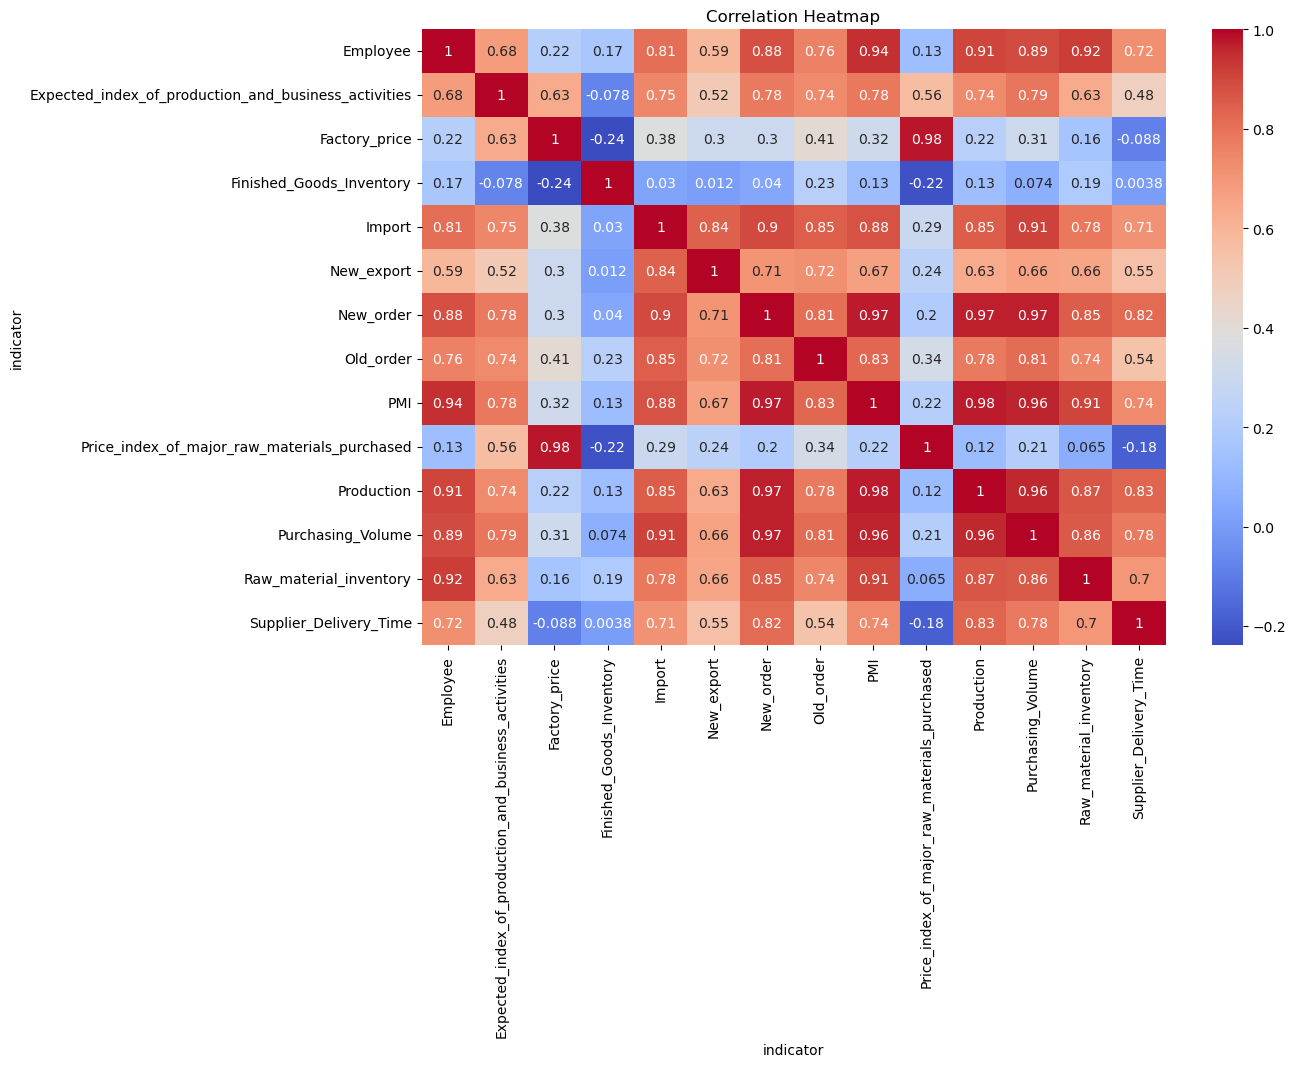

In [31]:
# Heatmap visualization
plt.figure(figsize=(12, 8))
sns.heatmap(df_wide.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig("D:\PYTHON/correlation_heatmap.png", bbox_inches='tight')
plt.show()

In [32]:
# Regression analysis
x = df_wide.drop(columns=["PMI"])
y = df_wide["PMI"]
model = LinearRegression()
model.fit(x, y)
coeff_df = pd.DataFrame({"indicator":x.columns, "Coefficient":model.coef_})
print("Coefficient of Regression")
print(coeff_df)
print("R²: ", model.score(x,y))

Coefficient of Regression
                                            indicator  Coefficient
0                                            Employee     0.202289
1   Expected_index_of_production_and_business_acti...     0.001184
2                                       Factory_price    -0.009618
3                            Finished_Goods_Inventory    -0.007063
4                                              Import    -0.003983
5                                          New_export     0.001193
6                                           New_order     0.304600
7                                           Old_order     0.004567
8        Price_index_of_major_raw_materials_purchased     0.004874
9                                          Production     0.244430
10                                  Purchasing_Volume    -0.006379
11                             Raw_material_inventory     0.107799
12                             Supplier_Delivery_Time    -0.147731
R²:  0.9999151582137796


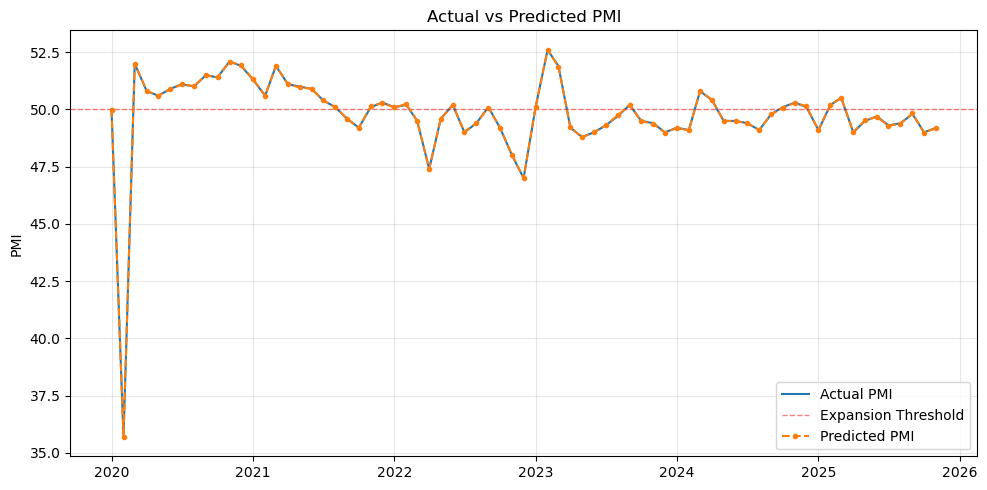

In [33]:
# Visualizing PMI and regression prediction
y_pred = model.predict(x)
plt.figure(figsize=(10, 5))
plt.plot(df_wide.index, y, label="Actual PMI")
plt.axhline(50, color='red', alpha=0.5, linestyle="--", label="Expansion Threshold", linewidth=1)
plt.plot(df_wide.index, y_pred, label="Predicted PMI", linestyle="--", marker='o', markersize=3)
plt.ylabel("PMI")
plt.title("Actual vs Predicted PMI")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("D:\PYTHON/actual_vs_predicted_pmi.png", bbox_inches='tight')
plt.show()

In [34]:
# Rolling regression
window = 12 
rolling_coefs = pd.DataFrame(index=df_wide.index[window-1:], columns=x.columns)

for start in range(len(df_wide) - window + 1):
    end = start + window
    x_window = x.iloc[start:end]
    y_window = y.iloc[start:end]
    
    model_window = LinearRegression()
    model_window.fit(x_window, y_window)
    
    rolling_coefs.iloc[start] = model_window.coef_

In [35]:
# Time series forecasting
arima_model = ARIMA(pmis["Value"], order=(1,1,1)) 
arima_fit = arima_model.fit()
forecast_arima = arima_fit.forecast(steps=6)

exp_model = ExponentialSmoothing(pmis["Value"], trend="add", seasonal=None)
exp_fit = exp_model.fit()
forecast_exp = exp_fit.forecast(6)

D:\Users\Jacyhsu\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Users\Jacyhsu\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


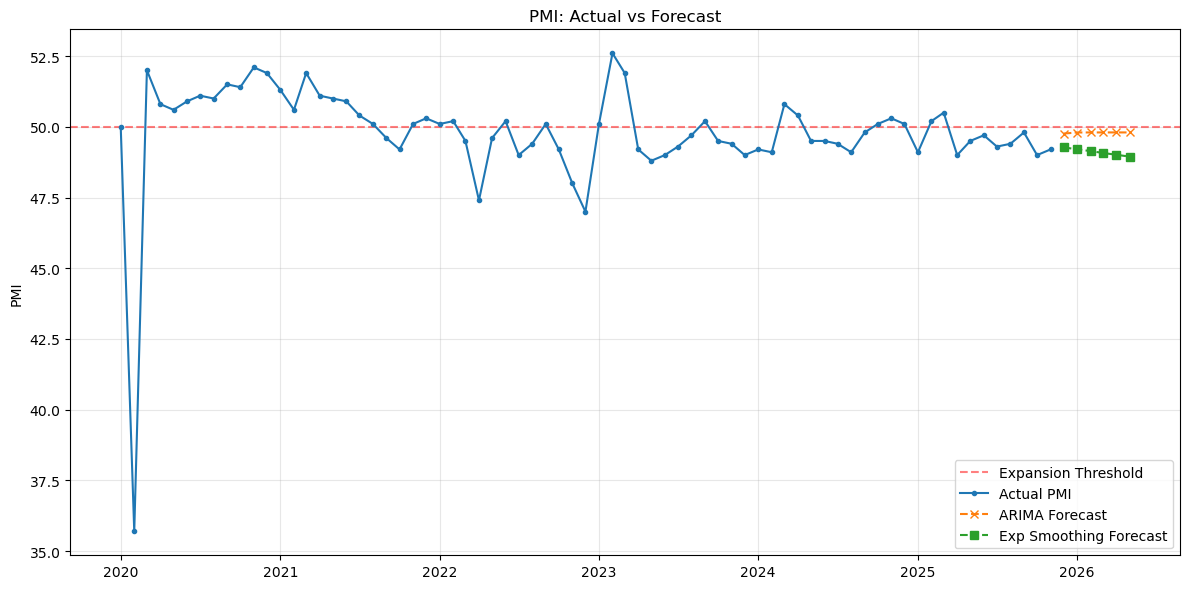

In [42]:
plt.figure(figsize=(12,6))
plt.axhline(50, color="red", alpha=0.5, linestyle="--", label='Expansion Threshold')
plt.plot(pmis.index, pmis["Value"], label="Actual PMI", marker='o', markersize=3) 
plt.plot(pd.date_range(pmis.index[-1]+pd.offsets.MonthBegin(1), periods=6, freq='MS'),
         forecast_arima, label="ARIMA Forecast", linestyle="--", marker='x')
plt.plot(pd.date_range(pmis.index[-1]+pd.offsets.MonthBegin(1), periods=6, freq='MS'),
         forecast_exp, label="Exp Smoothing Forecast", linestyle="--", marker='s')
plt.ylabel("PMI")
plt.title("PMI: Actual vs Forecast")
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("D:\PYTHON/actual_vs_forecast.png", bbox_inches='tight')
plt.show()